# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Find a similar neighborhood <a name="introduction"></a>

In this project we will try to find a similar **neighborhood** bewteen Two cities, **Toronto** and **New York**. 

Here is the scenario. James now is working in Toronto for a company and living in the Neighborhood **Cedarbrae** which in Borough **Scarborough**. He received another opportunity for a company locates on New York. He decided to accept this opportunity. Before he moves to New York, he wants to find a house with a neighborhood similar to which he is living in the Toronto. 

We will compare the neighborhood with their **Venues** as the first criterion. Then rank the similar neighborhood by the distance from **his new company in Greenwich Village**. 

We will use our data science powers to generate a most promissing neighborhoods based on these criterias. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholder.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* The similarity between different neighborhood according to its venues.
* Distance of neighborhood from his new company.

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* Boroughs list of **Toronto** and **New York** from web(New York: https://cocl.us/new_york_dataset / Toronto:https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M.)
* Same with above, we will obtain the neighborhood list from the web.
* Longitude and latitude will be obtained by using **Google Maps API reverse geocoding**
* Venues  will be obtained using **Foursquare API**

### Prepare the Neighborhood data for New York city

In [42]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import numpy
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import codecs
from urllib import request
import requests 
from bs4 import BeautifulSoup
import re
import time
print('Libraries imported.')

Libraries imported.


In [2]:
#!wget -q -O newyork_data.json https://cocl.us/new_york_dataset #if you r running in linux, please use single quotes to mark the file name
#print('Data downloaded!')

In [3]:
with open('newyork_data.json','r') as json_data:
    #print(json_data)
    newyork_data = json.load(json_data)

In [194]:
neighborhoods_data = newyork_data['features']

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_neighborhoods = pd.DataFrame(columns=column_names)

#Then let's loop through the data and fill the dataframe one row at a time.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

**Let's show the dataframe**

In [6]:
ny_neighborhoods.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


### Prepare Neighborhood the data for Toronto

#### Use the BeatuifulSoup to grab the table from website

In [7]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
req = request.Request(URL, headers={'User-Agent': 'Mozilla/4.0 (compatible; MSIE 5.5; Windows NT)'})
page = request.urlopen(req)

soup = BeautifulSoup(page, "html.parser")
page.close()
tables = soup.findAll('table')
tab = tables[0]
#print(tables)

col = []
for th in tab.tbody.findAll('th'):
    text = th.getText()
    text = re.sub(r'\n','',text)
    col.append(text)
toronto_pd = pd.DataFrame(columns = col)
df_index = 0
for tr in tab.tbody.findAll('tr'):
    row = []
    for td in tr.findAll('td'):        
        text = td.getText()
        text = re.sub(r'\n','',text)
        row.append(text)
        #print(text)
    if len(row) != 0: 
        #print(row)
        toronto_pd.loc[df_index] =row
        df_index = df_index + 1

**Let's check the data**

In [195]:
toronto_pd.columns = ['Postcode', 'Borough', 'Neighborhood']
toronto_pd.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


But there is a lot invalid Borough and "Not assigned". Let's get the valid Borough value list and remove the "Not assigned" in borough

In [9]:

valid_borough  = list(toronto_pd.Borough)
valid_borough_set = set(valid_borough)
#print(valid_borough_set)
valid_borough_set.remove('Not assigned')
#print(valid_borough_set)
toronto_pd = toronto_pd[toronto_pd.Borough.isin(list(valid_borough_set))]
#reset the index
toronto_pd = toronto_pd.reset_index(drop = True)


Use the borough name instead of the neighborhood name if it is "Not assigned"

In [10]:
print(len(toronto_pd))
for i in range(0, len(toronto_pd)):
    print#i)
    toronto_pd.iloc[i]['Neighborhood']
    if toronto_pd.iloc[i]["Neighborhood"] == "Not assigned":
        toronto_pd.iloc[i]['Neighborhood'] = toronto_pd.iloc[i]['Borough']
toronto_pd.head(10)

210


,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Downtown Toronto,Queen's Park
6,M9A,Etobicoke,Islington Avenue
7,M1B,Scarborough,Rouge
8,M1B,Scarborough,Malvern
9,M3B,North York,Don Mills North


Combine the Neighborhood name if the Postcode and Borough is same and show the final table

In [11]:
toronto_pd = toronto_pd.groupby(['Postcode','Borough'],as_index=False).agg(','.join)
toronto_pd.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Then let's combine the coordinates and Postcode from a csv.

In [12]:
!wget --quiet http://cocl.us/Geospatial_data -O Torontocoordinates.csv

In [13]:
toronto_coordinates = pd.read_csv('Torontocoordinates.csv',skiprows = 1,header = None,names  = ["Postcode","Latitude","Longitude"])
postcode_list = list(toronto_pd.Postcode)
toronto_coordinates = toronto_coordinates[toronto_coordinates.Postcode.isin((postcode_list))]

In [14]:
final_pd = pd.merge(toronto_pd, toronto_coordinates, how='outer', on=['Postcode'])
final_pd.head(10)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


Above it the final Data for Toronto, include the Neighborhood and coordinates.

### Grab the venues from the Foursquare API

Now we already have the coordinates data for every single Neighborhood. Next we can use the coordinates information to grab the nubmer venues of very categories that most currently checked in. We consider that the venues of a neighborhood is the reason why that people will decide to live there. Then if two neighborhoods have similar veneus, we can consider they are similar neighborhood.

Here is the top level categories we will use.

In [17]:
top_level_categories={
        "Arts & Entertainment":"4d4b7104d754a06370d81259",
        "College & University":"4d4b7105d754a06372d81259",
        "Event":"4d4b7105d754a06373d81259",
        "Food":"4d4b7105d754a06374d81259",
        "Nightlife Spot":"4d4b7105d754a06376d81259",
        "Professional & Other Places":"4d4b7105d754a06375d81259",
        "Outdoors & Recreation":"4d4b7105d754a06377d81259",
        "Residence":"4e67e38e036454776db1fb3a",
        "Shop & Service":"4d4b7105d754a06378d81259",
        "Travel & Transport":"4d4b7105d754a06379d81259"
        
}

And we will limit the maxiumn venues number that returned from Foursquare to **50**, set the search redius to **500 meters**.

In [139]:
CLIENT_ID = 'T13VM3HJA5JNNM33QDKSGJQ5T33NMJ0VQ1ONAC1JCQARACYG' # your Foursquare ID
CLIENT_SECRET = 'KCBXXEV2Q3LIO5YNRAGAWJMESLOLYBKSOY4MOMALBSIBU5ET' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 50
radius = 500

Your credentails:
CLIENT_ID: T13VM3HJA5JNNM33QDKSGJQ5T33NMJ0VQ1ONAC1JCQARACYG
CLIENT_SECRET:KCBXXEV2Q3LIO5YNRAGAWJMESLOLYBKSOY4MOMALBSIBU5ET


Define the function to grab the venues nubmer by the category

In [34]:
def get_venues_number_by_category(name, lat, lng, category_name, radius=500):
        # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT,
        'checkin',
        top_level_categories[category_name])
            
        # make the GET request
    print(requests.get(url))
        # return only relevant information for each nearby venue
    results = requests.get(url).json()["response"]['venues']
    print("The total venues with %s is: %d" %(category_name,len(results)))
    return(len(results))

Let's grab the venues nubmer of Toronto and New Year

In [141]:
list_for_all_neighborhood_in_toronto = []
for neighborhood_name,lat,lng in zip(final_pd['Neighborhood'],final_pd['Latitude'],final_pd['Longitude']):
    list_for_one_neighborhood_in_toronto = [neighborhood_name]
    time.sleep(1)
    for category_name,category_id in top_level_categories.items():
        list_for_one_neighborhood_in_toronto.append(get_venues_number_by_category(name = neighborhood_name,
                                                                       lat = lat,
                                                                       lng= lng,
                                                                       category_name = category_name))
    list_for_all_neighborhood_in_toronto.append(list_for_one_neighborhood_in_toronto)


list_for_all_neighborhood_in_ny= []
for neighborhood_name,lat,lng in zip(ny_neighborhoods['Neighborhood'],ny_neighborhoods['Latitude'],ny_neighborhoods['Longitude']):
    list_for_one_neighborhood_in_ny = [neighborhood_name]
    time.sleep(1)
    for category_name,category_id in top_level_categories.items(): 
        list_for_one_neighborhood_in_ny.append(get_venues_number_by_category(name = neighborhood_name,
                                                                       lat = lat,
                                                                       lng= lng,
                                                                       category_name = category_name))
    list_for_all_neighborhood_in_ny.append(list_for_one_neighborhood_in_ny)

<Response [200]>
The total venues with Arts & Entertainment is: 1
<Response [200]>
The total venues with College & University is: 1
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 25
<Response [200]>
The total venues with Nightlife Spot is: 1
<Response [200]>
The total venues with Professional & Other Places is: 34
<Response [200]>
The total venues with Outdoors & Recreation is: 10
<Response [200]>
The total venues with Residence is: 1
<Response [200]>
The total venues with Shop & Service is: 30
<Response [200]>
The total venues with Travel & Transport is: 3
<Response [200]>
The total venues with Arts & Entertainment is: 5
<Response [200]>
The total venues with College & University is: 2
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 14
<Response [200]>
The total venues with Nightlife Spot is: 2
<Response [200]>
The total venues with Professional & Other Places is: 14
<Response [200]>

<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 1
<Response [200]>
The total venues with Professional & Other Places is: 41
<Response [200]>
The total venues with Outdoors & Recreation is: 18
<Response [200]>
The total venues with Residence is: 17
<Response [200]>
The total venues with Shop & Service is: 39
<Response [200]>
The total venues with Travel & Transport is: 9
<Response [200]>
The total venues with Arts & Entertainment is: 1
<Response [200]>
The total venues with College & University is: 4
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 1
<Response [200]>
The total venues with Professional & Other Places is: 42
<Response [200]>
The total venues with Outdoors & Recreation is: 18
<Response [200]>
The total venues with Residence is: 3
<Response [200]>
The total venues with Shop & Service is: 39
<Response [200

<Response [200]>
The total venues with Outdoors & Recreation is: 27
<Response [200]>
The total venues with Residence is: 12
<Response [200]>
The total venues with Shop & Service is: 36
<Response [200]>
The total venues with Travel & Transport is: 5
<Response [200]>
The total venues with Arts & Entertainment is: 29
<Response [200]>
The total venues with College & University is: 8
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 48
<Response [200]>
The total venues with Nightlife Spot is: 14
<Response [200]>
The total venues with Professional & Other Places is: 48
<Response [200]>
The total venues with Outdoors & Recreation is: 45
<Response [200]>
The total venues with Residence is: 24
<Response [200]>
The total venues with Shop & Service is: 38
<Response [200]>
The total venues with Travel & Transport is: 10
<Response [200]>
The total venues with Arts & Entertainment is: 2
<Response [200]>
The total venues with College & University is: 1

<Response [200]>
The total venues with Travel & Transport is: 12
<Response [200]>
The total venues with Arts & Entertainment is: 35
<Response [200]>
The total venues with College & University is: 22
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 49
<Response [200]>
The total venues with Professional & Other Places is: 47
<Response [200]>
The total venues with Outdoors & Recreation is: 39
<Response [200]>
The total venues with Residence is: 23
<Response [200]>
The total venues with Shop & Service is: 47
<Response [200]>
The total venues with Travel & Transport is: 27
<Response [200]>
The total venues with Arts & Entertainment is: 39
<Response [200]>
The total venues with College & University is: 19
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 47
<Response [200]>


<Response [200]>
The total venues with College & University is: 49
<Response [200]>
The total venues with Event is: 4
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 49
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 43
<Response [200]>
The total venues with Residence is: 48
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 25
<Response [200]>
The total venues with Arts & Entertainment is: 49
<Response [200]>
The total venues with College & University is: 50
<Response [200]>
The total venues with Event is: 7
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 50
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 44
<Respon

The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 50
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 41
<Response [200]>
The total venues with Residence is: 50
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 36
<Response [200]>
The total venues with Arts & Entertainment is: 50
<Response [200]>
The total venues with College & University is: 50
<Response [200]>
The total venues with Event is: 4
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 50
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 42
<Response [200]>
The total venues with Residence is: 49
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The tota

<Response [200]>
The total venues with Outdoors & Recreation is: 17
<Response [200]>
The total venues with Residence is: 10
<Response [200]>
The total venues with Shop & Service is: 32
<Response [200]>
The total venues with Travel & Transport is: 9
<Response [200]>
The total venues with Arts & Entertainment is: 8
<Response [200]>
The total venues with College & University is: 1
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 45
<Response [200]>
The total venues with Nightlife Spot is: 9
<Response [200]>
The total venues with Professional & Other Places is: 40
<Response [200]>
The total venues with Outdoors & Recreation is: 16
<Response [200]>
The total venues with Residence is: 9
<Response [200]>
The total venues with Shop & Service is: 36
<Response [200]>
The total venues with Travel & Transport is: 7
<Response [200]>
The total venues with Arts & Entertainment is: 11
<Response [200]>
The total venues with College & University is: 1
<R

<Response [200]>
The total venues with Travel & Transport is: 16
<Response [200]>
The total venues with Arts & Entertainment is: 2
<Response [200]>
The total venues with College & University is: 0
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 6
<Response [200]>
The total venues with Nightlife Spot is: 1
<Response [200]>
The total venues with Professional & Other Places is: 15
<Response [200]>
The total venues with Outdoors & Recreation is: 14
<Response [200]>
The total venues with Residence is: 3
<Response [200]>
The total venues with Shop & Service is: 14
<Response [200]>
The total venues with Travel & Transport is: 8
<Response [200]>
The total venues with Arts & Entertainment is: 5
<Response [200]>
The total venues with College & University is: 4
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 19
<Response [200]>
The total venues with Nightlife Spot is: 4
<Response [200]>
The total

<Response [200]>
The total venues with Event is: 1
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 30
<Response [200]>
The total venues with Professional & Other Places is: 47
<Response [200]>
The total venues with Outdoors & Recreation is: 46
<Response [200]>
The total venues with Residence is: 48
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 29
<Response [200]>
The total venues with Arts & Entertainment is: 19
<Response [200]>
The total venues with College & University is: 49
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 28
<Response [200]>
The total venues with Professional & Other Places is: 49
<Response [200]>
The total venues with Outdoors & Recreation is: 46
<Response [200]>
The total venues with Residence is: 48
<Response [200]>
T

<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 43
<Response [200]>
The total venues with Residence is: 46
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 37
<Response [200]>
The total venues with Arts & Entertainment is: 42
<Response [200]>
The total venues with College & University is: 17
<Response [200]>
The total venues with Event is: 1
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 19
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 43
<Response [200]>
The total venues with Residence is: 46
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 40
<Response [200]>
The total venues with Arts & Entertain

<Response [200]>
The total venues with Residence is: 19
<Response [200]>
The total venues with Shop & Service is: 49
<Response [200]>
The total venues with Travel & Transport is: 38
<Response [200]>
The total venues with Arts & Entertainment is: 46
<Response [200]>
The total venues with College & University is: 19
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 44
<Response [200]>
The total venues with Professional & Other Places is: 49
<Response [200]>
The total venues with Outdoors & Recreation is: 42
<Response [200]>
The total venues with Residence is: 46
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 43
<Response [200]>
The total venues with Arts & Entertainment is: 24
<Response [200]>
The total venues with College & University is: 22
<Response [200]>
The total venues with Event is: 0
<Response [2

The total venues with Travel & Transport is: 37
<Response [200]>
The total venues with Arts & Entertainment is: 43
<Response [200]>
The total venues with College & University is: 28
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 50
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 42
<Response [200]>
The total venues with Residence is: 49
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 41
<Response [200]>
The total venues with Arts & Entertainment is: 25
<Response [200]>
The total venues with College & University is: 18
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 31
<Response [200]>
The total venues 

The total venues with College & University is: 9
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 46
<Response [200]>
The total venues with Nightlife Spot is: 46
<Response [200]>
The total venues with Professional & Other Places is: 42
<Response [200]>
The total venues with Outdoors & Recreation is: 29
<Response [200]>
The total venues with Residence is: 18
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 32
<Response [200]>
The total venues with Arts & Entertainment is: 41
<Response [200]>
The total venues with College & University is: 18
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 35
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 47
<Response [200]>
The tota

<Response [200]>
The total venues with Nightlife Spot is: 50
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 48
<Response [200]>
The total venues with Residence is: 50
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 48
<Response [200]>
The total venues with Arts & Entertainment is: 50
<Response [200]>
The total venues with College & University is: 46
<Response [200]>
The total venues with Event is: 5
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 50
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 46
<Response [200]>
The total venues with Residence is: 50
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport i

<Response [200]>
The total venues with Outdoors & Recreation is: 43
<Response [200]>
The total venues with Residence is: 35
<Response [200]>
The total venues with Shop & Service is: 46
<Response [200]>
The total venues with Travel & Transport is: 34
<Response [200]>
The total venues with Arts & Entertainment is: 22
<Response [200]>
The total venues with College & University is: 11
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 29
<Response [200]>
The total venues with Professional & Other Places is: 44
<Response [200]>
The total venues with Outdoors & Recreation is: 49
<Response [200]>
The total venues with Residence is: 11
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 39
<Response [200]>
The total venues with Arts & Entertainment is: 46
<Response [200]>
The total venues with College & University is

The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 43
<Response [200]>
The total venues with Arts & Entertainment is: 50
<Response [200]>
The total venues with College & University is: 38
<Response [200]>
The total venues with Event is: 9
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 50
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 48
<Response [200]>
The total venues with Residence is: 50
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 45
<Response [200]>
The total venues with Arts & Entertainment is: 50
<Response [200]>
The total venues with College & University is: 37
<Response [200]>
The total venues with Event is: 4
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues 

The total venues with Arts & Entertainment is: 50
<Response [200]>
The total venues with College & University is: 50
<Response [200]>
The total venues with Event is: 1
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 50
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 49
<Response [200]>
The total venues with Residence is: 50
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 48
<Response [200]>
The total venues with Arts & Entertainment is: 46
<Response [200]>
The total venues with College & University is: 49
<Response [200]>
The total venues with Event is: 1
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 50
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The tota

<Response [200]>
The total venues with Event is: 5
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 50
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 42
<Response [200]>
The total venues with Residence is: 50
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 49
<Response [200]>
The total venues with Arts & Entertainment is: 50
<Response [200]>
The total venues with College & University is: 50
<Response [200]>
The total venues with Event is: 5
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 50
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 46
<Response [200]>
The total venues with Residence is: 50
<Response [200]>
T

<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 47
<Response [200]>
The total venues with Residence is: 49
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 31
<Response [200]>
The total venues with Arts & Entertainment is: 23
<Response [200]>
The total venues with College & University is: 16
<Response [200]>
The total venues with Event is: 1
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 43
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 44
<Response [200]>
The total venues with Residence is: 49
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 44
<Response [200]>
The total venues with Arts & Entertain

<Response [200]>
The total venues with Residence is: 2
<Response [200]>
The total venues with Shop & Service is: 39
<Response [200]>
The total venues with Travel & Transport is: 40
<Response [200]>
The total venues with Arts & Entertainment is: 14
<Response [200]>
The total venues with College & University is: 9
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 49
<Response [200]>
The total venues with Nightlife Spot is: 26
<Response [200]>
The total venues with Professional & Other Places is: 40
<Response [200]>
The total venues with Outdoors & Recreation is: 44
<Response [200]>
The total venues with Residence is: 5
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 25
<Response [200]>
The total venues with Arts & Entertainment is: 17
<Response [200]>
The total venues with College & University is: 6
<Response [200]>
The total venues with Event is: 1
<Response [200]>

<Response [200]>
The total venues with Arts & Entertainment is: 19
<Response [200]>
The total venues with College & University is: 6
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 49
<Response [200]>
The total venues with Nightlife Spot is: 12
<Response [200]>
The total venues with Professional & Other Places is: 45
<Response [200]>
The total venues with Outdoors & Recreation is: 34
<Response [200]>
The total venues with Residence is: 5
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 35
<Response [200]>
The total venues with Arts & Entertainment is: 12
<Response [200]>
The total venues with College & University is: 3
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 45
<Response [200]>
The total venues with Nightlife Spot is: 16
<Response [200]>
The total venues with Professional & Other Places is: 49
<Response [

<Response [200]>
The total venues with Food is: 42
<Response [200]>
The total venues with Nightlife Spot is: 5
<Response [200]>
The total venues with Professional & Other Places is: 43
<Response [200]>
The total venues with Outdoors & Recreation is: 40
<Response [200]>
The total venues with Residence is: 25
<Response [200]>
The total venues with Shop & Service is: 41
<Response [200]>
The total venues with Travel & Transport is: 34
<Response [200]>
The total venues with Arts & Entertainment is: 3
<Response [200]>
The total venues with College & University is: 2
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 15
<Response [200]>
The total venues with Nightlife Spot is: 0
<Response [200]>
The total venues with Professional & Other Places is: 43
<Response [200]>
The total venues with Outdoors & Recreation is: 30
<Response [200]>
The total venues with Residence is: 10
<Response [200]>
The total venues with Shop & Service is: 16
<Response [2

<Response [200]>
The total venues with Outdoors & Recreation is: 11
<Response [200]>
The total venues with Residence is: 3
<Response [200]>
The total venues with Shop & Service is: 48
<Response [200]>
The total venues with Travel & Transport is: 18
<Response [200]>
The total venues with Arts & Entertainment is: 28
<Response [200]>
The total venues with College & University is: 12
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 31
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 45
<Response [200]>
The total venues with Residence is: 49
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 39
<Response [200]>
The total venues with Arts & Entertainment is: 2
<Response [200]>
The total venues with College & University is: 

The total venues with Shop & Service is: 44
<Response [200]>
The total venues with Travel & Transport is: 30
<Response [200]>
The total venues with Arts & Entertainment is: 48
<Response [200]>
The total venues with College & University is: 49
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 45
<Response [200]>
The total venues with Nightlife Spot is: 45
<Response [200]>
The total venues with Professional & Other Places is: 46
<Response [200]>
The total venues with Outdoors & Recreation is: 42
<Response [200]>
The total venues with Residence is: 33
<Response [200]>
The total venues with Shop & Service is: 33
<Response [200]>
The total venues with Travel & Transport is: 36
<Response [200]>
The total venues with Arts & Entertainment is: 2
<Response [200]>
The total venues with College & University is: 1
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 34
<Response [200]>
The total venues wi

<Response [200]>
The total venues with College & University is: 6
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 29
<Response [200]>
The total venues with Nightlife Spot is: 7
<Response [200]>
The total venues with Professional & Other Places is: 34
<Response [200]>
The total venues with Outdoors & Recreation is: 20
<Response [200]>
The total venues with Residence is: 0
<Response [200]>
The total venues with Shop & Service is: 29
<Response [200]>
The total venues with Travel & Transport is: 9
<Response [200]>
The total venues with Arts & Entertainment is: 20
<Response [200]>
The total venues with College & University is: 5
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 28
<Response [200]>
The total venues with Nightlife Spot is: 20
<Response [200]>
The total venues with Professional & Other Places is: 42
<Response [200]>
The total venues with Outdoors & Recreation is: 33
<Response [2

<Response [200]>
The total venues with Nightlife Spot is: 8
<Response [200]>
The total venues with Professional & Other Places is: 45
<Response [200]>
The total venues with Outdoors & Recreation is: 43
<Response [200]>
The total venues with Residence is: 6
<Response [200]>
The total venues with Shop & Service is: 34
<Response [200]>
The total venues with Travel & Transport is: 32
<Response [200]>
The total venues with Arts & Entertainment is: 12
<Response [200]>
The total venues with College & University is: 2
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 43
<Response [200]>
The total venues with Nightlife Spot is: 10
<Response [200]>
The total venues with Professional & Other Places is: 43
<Response [200]>
The total venues with Outdoors & Recreation is: 42
<Response [200]>
The total venues with Residence is: 9
<Response [200]>
The total venues with Shop & Service is: 41
<Response [200]>
The total venues with Travel & Transport is: 3

<Response [200]>
The total venues with Residence is: 2
<Response [200]>
The total venues with Shop & Service is: 30
<Response [200]>
The total venues with Travel & Transport is: 17
<Response [200]>
The total venues with Arts & Entertainment is: 13
<Response [200]>
The total venues with College & University is: 5
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 47
<Response [200]>
The total venues with Nightlife Spot is: 14
<Response [200]>
The total venues with Professional & Other Places is: 41
<Response [200]>
The total venues with Outdoors & Recreation is: 22
<Response [200]>
The total venues with Residence is: 4
<Response [200]>
The total venues with Shop & Service is: 39
<Response [200]>
The total venues with Travel & Transport is: 19
<Response [200]>
The total venues with Arts & Entertainment is: 15
<Response [200]>
The total venues with College & University is: 10
<Response [200]>
The total venues with Event is: 0
<Response [200]

<Response [200]>
The total venues with Arts & Entertainment is: 41
<Response [200]>
The total venues with College & University is: 49
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 41
<Response [200]>
The total venues with Nightlife Spot is: 23
<Response [200]>
The total venues with Professional & Other Places is: 44
<Response [200]>
The total venues with Outdoors & Recreation is: 45
<Response [200]>
The total venues with Residence is: 10
<Response [200]>
The total venues with Shop & Service is: 33
<Response [200]>
The total venues with Travel & Transport is: 20
<Response [200]>
The total venues with Arts & Entertainment is: 33
<Response [200]>
The total venues with College & University is: 11
<Response [200]>
The total venues with Event is: 1
<Response [200]>
The total venues with Food is: 47
<Response [200]>
The total venues with Nightlife Spot is: 22
<Response [200]>
The total venues with Professional & Other Places is: 45
<Respons

The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 48
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 43
<Response [200]>
The total venues with Residence is: 49
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 42
<Response [200]>
The total venues with Arts & Entertainment is: 18
<Response [200]>
The total venues with College & University is: 48
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 34
<Response [200]>
The total venues with Professional & Other Places is: 49
<Response [200]>
The total venues with Outdoors & Recreation is: 45
<Response [200]>
The total venues with Residence is: 48
<Response [200]>
The total venues w

<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 45
<Response [200]>
The total venues with Residence is: 50
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 38
<Response [200]>
The total venues with Arts & Entertainment is: 29
<Response [200]>
The total venues with College & University is: 14
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 50
<Response [200]>
The total venues with Nightlife Spot is: 35
<Response [200]>
The total venues with Professional & Other Places is: 50
<Response [200]>
The total venues with Outdoors & Recreation is: 48
<Response [200]>
The total venues with Residence is: 48
<Response [200]>
The total venues with Shop & Service is: 50
<Response [200]>
The total venues with Travel & Transport is: 40
<Response [200]>
The total venues with Arts & Entertain

The total venues with Residence is: 2
<Response [200]>
The total venues with Shop & Service is: 46
<Response [200]>
The total venues with Travel & Transport is: 32
<Response [200]>
The total venues with Arts & Entertainment is: 9
<Response [200]>
The total venues with College & University is: 2
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues with Food is: 48
<Response [200]>
The total venues with Nightlife Spot is: 27
<Response [200]>
The total venues with Professional & Other Places is: 48
<Response [200]>
The total venues with Outdoors & Recreation is: 31
<Response [200]>
The total venues with Residence is: 7
<Response [200]>
The total venues with Shop & Service is: 45
<Response [200]>
The total venues with Travel & Transport is: 37
<Response [200]>
The total venues with Arts & Entertainment is: 30
<Response [200]>
The total venues with College & University is: 35
<Response [200]>
The total venues with Event is: 0
<Response [200]>
The total venues

Let's have a look for the lists

In [196]:
list_for_all_neighborhood_in_ny

[['Wakefield', 12, 5, 0, 48, 18, 47, 14, 14, 49, 36],
 ['Co-op City', 13, 4, 0, 48, 11, 44, 39, 22, 50, 43],
 ['Eastchester', 10, 9, 0, 48, 13, 50, 27, 10, 50, 36],
 ['Fieldston', 19, 49, 1, 50, 30, 47, 46, 48, 50, 29],
 ['Riverdale', 19, 49, 0, 50, 28, 49, 46, 48, 49, 27],
 ['Kingsbridge', 35, 49, 1, 50, 48, 50, 45, 48, 50, 50],
 ['Marble Hill', 35, 28, 0, 50, 46, 50, 45, 49, 50, 47],
 ['Woodlawn', 15, 6, 0, 48, 41, 46, 34, 19, 49, 39],
 ['Norwood', 25, 36, 0, 50, 25, 50, 46, 46, 50, 43],
 ['Williamsbridge', 19, 16, 0, 47, 26, 45, 31, 30, 50, 35],
 ['Baychester', 15, 4, 0, 49, 8, 41, 41, 19, 50, 42],
 ['Pelham Parkway', 24, 36, 0, 50, 22, 50, 37, 36, 50, 40],
 ['City Island', 6, 1, 0, 34, 9, 18, 40, 3, 37, 27],
 ['Bedford Park', 34, 50, 2, 50, 31, 50, 47, 46, 50, 39],
 ['University Heights', 22, 47, 0, 50, 47, 50, 43, 47, 50, 38],
 ['Morris Heights', 27, 48, 0, 50, 41, 50, 45, 48, 50, 36],
 ['Fordham', 41, 49, 2, 50, 45, 50, 43, 46, 50, 37],
 ['East Tremont', 42, 17, 1, 50, 19, 50, 43

In [198]:
print(list_for_all_neighborhood_in_toronto)

[['Rouge,Malvern', 1, 1, 0, 25, 1, 34, 10, 1, 30, 3], ['Highland Creek,Rouge Hill,Port Union', 5, 2, 0, 14, 2, 14, 5, 3, 28, 2], ['Guildwood,Morningside,West Hill', 0, 2, 0, 47, 5, 45, 15, 15, 37, 18], ['Woburn', 1, 0, 0, 28, 2, 22, 4, 6, 31, 6], ['Cedarbrae', 6, 5, 0, 48, 5, 36, 33, 26, 35, 13], ['Scarborough Village', 5, 5, 0, 34, 2, 32, 13, 10, 38, 10], ['East Birchmount Park,Ionview,Kennedy Park', 4, 1, 0, 45, 6, 43, 8, 21, 40, 13], ['Clairlea,Golden Mile,Oakridge', 6, 4, 0, 27, 5, 33, 20, 11, 30, 18], ['Cliffcrest,Cliffside,Scarborough Village West', 2, 2, 0, 34, 4, 31, 17, 5, 32, 6], ['Birch Cliff,Cliffside West', 6, 4, 0, 27, 6, 33, 18, 3, 33, 9], ['Dorset Park,Scarborough Town Centre,Wexford Heights', 6, 0, 0, 48, 1, 45, 14, 7, 41, 9], ['Maryvale,Wexford', 2, 3, 1, 48, 10, 43, 8, 2, 32, 11], ['Agincourt', 10, 6, 0, 48, 8, 39, 17, 3, 41, 5], ["Clarks Corners,Sullivan,Tam O'Shanter", 1, 2, 0, 50, 1, 41, 18, 17, 39, 9], ["Agincourt North,L'Amoreaux East,Milliken,Steeles East", 1, 

Transfer the list ot the dataframe

In [51]:
columns = ["Neighborhood"]
for category in list(top_level_categories.keys()):
    columns.append(category)
print(columns)

['Neighborhood', 'Arts & Entertainment', 'College & University', 'Event', 'Food', 'Nightlife Spot', 'Professional & Other Places', 'Outdoors & Recreation', 'Residence', 'Shop & Service', 'Travel & Transport']


In [144]:
df_for_all_neighborhood_in_ny = pd.DataFrame(list_for_all_neighborhood_in_ny,columns = columns)
df_for_all_neighborhood_in_ny.head(10)
df_for_all_neighborhood_in_toronto = pd.DataFrame(list_for_all_neighborhood_in_toronto,columns = columns)
df_for_all_neighborhood_in_toronto.head(10)

,Neighborhood,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Professional & Other Places,Outdoors & Recreation,Residence,Shop & Service,Travel & Transport
0,"Rouge,Malvern",1,1,0,25,1,34,10,1,30,3
1,"Highland Creek,Rouge Hill,Port Union",5,2,0,14,2,14,5,3,28,2
2,"Guildwood,Morningside,West Hill",0,2,0,47,5,45,15,15,37,18
3,Woburn,1,0,0,28,2,22,4,6,31,6
4,Cedarbrae,6,5,0,48,5,36,33,26,35,13
5,Scarborough Village,5,5,0,34,2,32,13,10,38,10
6,"East Birchmount Park,Ionview,Kennedy Park",4,1,0,45,6,43,8,21,40,13
7,"Clairlea,Golden Mile,Oakridge",6,4,0,27,5,33,20,11,30,18
8,"Cliffcrest,Cliffside,Scarborough Village West",2,2,0,34,4,31,17,5,32,6
9,"Birch Cliff,Cliffside West",6,4,0,27,6,33,18,3,33,9


Combine the data from **Cedarbrae** and From **New York**

In [146]:
cedarbrae_venues_count = df_for_all_neighborhood_in_toronto[df_for_all_neighborhood_in_toronto.Neighborhood.isin(list(['Cedarbrae']))]
final_venues_count_df = df_for_all_neighborhood_in_ny.append(cedarbrae_venues_count)

**Let's shows the final data**

In [147]:
final_venues_count_df.head(10)

,Neighborhood,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Professional & Other Places,Outdoors & Recreation,Residence,Shop & Service,Travel & Transport
0,Wakefield,12,5,0,48,18,47,14,14,49,36
1,Co-op City,13,4,0,48,11,44,39,22,50,43
2,Eastchester,10,9,0,48,13,50,27,10,50,36
3,Fieldston,19,49,1,50,30,47,46,48,50,29
4,Riverdale,19,49,0,50,28,49,46,48,49,27
5,Kingsbridge,35,49,1,50,48,50,45,48,50,50
6,Marble Hill,35,28,0,50,46,50,45,49,50,47
7,Woodlawn,15,6,0,48,41,46,34,19,49,39
8,Norwood,25,36,0,50,25,50,46,46,50,43
9,Williamsbridge,19,16,0,47,26,45,31,30,50,35


**Now we got all the data we need for our target.** Next we will introduce the Methodology of how to find a similar Neighborhood.

## Methodology <a name="methodology"></a>

### Overview the Methodology

In this project we will focus on how to use the neighborhood data to find out the alternative neighborhoods that can meet our stakeholder's requests.

To find out the alternative neighborhods, the **first step** is collect the data: neighborhood list/venue category list of every neighborhood/coordinate of ervry neighborhood. In the [Date](#data) section, we already pretreated the data that used in this project. 

**Second step** is to build the algorithm that can meansure similarity bewteen different neighborhoods. In second step, there will be 2 parts. One, explore the data to see if any data we can discard. Two, use the number of every categories as the components of vector and calcuate the Euclidean distance.

**Third step** will use the coordinate data to calcuate the distance between the company location and the Top 5 similar neighborhood and will rank them base on the distance. 

**Finally**, **3 neighborhoods** can be recommended to our stakeholder which can meet the two criterions: with similar venues in the neigborhood and close to his company. 

## Analysis <a name="analysis"></a>

### Explore the Data

Let's use the boxplot to explore the data(showing the average count, spread and outliers).

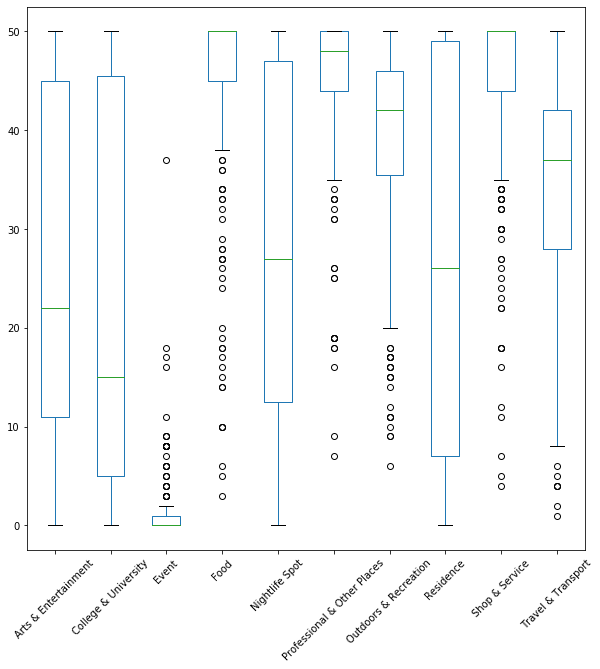

In [148]:
final_venues_count_df.plot(kind = "box",figsize = [10,10],rot=45)

We limit the maximun venues number for every category to 50, and set the radius to 500 meters.

From the boxplot, we can see, the most frequent category **Food**, followed by **Professional & Other Places**. The 3rd place is **Outdoors & Recreation**. Event has very little data, so we’ll discard it. 

In [156]:
#Drop the venues data of Event.
final_venues_count_df = final_venues_count_df.drop(["Event"],axis = 1)
final_venues_count_df

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Professional & Other Places,Outdoors & Recreation,Residence,Shop & Service,Travel & Transport
0,Wakefield,12,5,48,18,47,14,14,49,36
1,Co-op City,13,4,48,11,44,39,22,50,43
2,Eastchester,10,9,48,13,50,27,10,50,36
3,Fieldston,19,49,50,30,47,46,48,50,29
4,Riverdale,19,49,50,28,49,46,48,49,27
5,Kingsbridge,35,49,50,48,50,45,48,50,50
6,Marble Hill,35,28,50,46,50,45,49,50,47
7,Woodlawn,15,6,48,41,46,34,19,49,39
8,Norwood,25,36,50,25,50,46,46,50,43
9,Williamsbridge,19,16,47,26,45,31,30,50,35


### Calculate the Similarity 

Now we have the venues number of every category, then we can use the venues numbers as the componentes of the vector. And we can calculate the Euclidean distance between every two vectors. If two vectors are close to ecah other, that means they are similar to each other. Below function is used for calculating the Euclidean distance. 

In [82]:
def cal_distance_between_vector(vector1,vector2):
    vector1 = vector1.drop(["Neighborhood"],axis= 1).values
    vector2 = vector2.drop(["Neighborhood"],axis= 1).values
    distance = np.linalg.norm(vector1-vector2)
    #distance = np.dot(vector1,vector2)/(np.linalg.norm(vector1)*(np.linalg.norm(vector2)))
    return distance

Then we can calculate the distance between every 2 vectors and sort the distance. After that, we can get the **Top 5** similar Neighborhoods. 

In [163]:
distance_list = []
for i in range(0, len(final_venues_count_df)):
    if final_venues_count_list.iloc[i]["Neighborhood"] == "Cedarbrae":
        continue
    #final_grouped.iloc[i]
    vector1 = final_venues_count_df.loc[final_venues_count_df.Neighborhood.isin(list(['Cedarbrae']))]
    vector2 = final_venues_count_df.iloc[[i]]
    distance = cal_distance_between_vector(vector1,vector2)
    name = vector2.Neighborhood.values[0]
    #print(name)
    distance_list.append([(name),distance])
#print(distance_list)
distance_df = pd.DataFrame(distance_list,columns=["Neighborhood","Distance"])
distance_df = distance_df.sort_values(by="Distance",axis=0)
distance_df.reset_index(drop=True, inplace=True)
distance_df

,Neighborhood,Distance
0,Throgs Neck,21.189620
1,Glen Oaks,23.958297
2,Beechhurst,24.899799
3,Bay Terrace,25.377155
4,Bay Terrace,26.191602
5,Rosebank,26.907248
6,Little Neck,26.981475
7,Midland Beach,27.018512
8,Prince's Bay,27.386128
9,Sea Gate,27.531800


From the above list, the most similar neighborhood with **Cedarbrae** is **Throgs Neck**. Let's output the venues nubmer of **Cedarbrae** and **Throgs Neck*

In [165]:
vector_of_Throgs_Neck = final_venues_count_df.loc[final_venues_count_df.Neighborhood =="Throgs Neck",:]
vector_of_Throgs_Neck

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Professional & Other Places,Outdoors & Recreation,Residence,Shop & Service,Travel & Transport
28,Throgs Neck,9,5,46,14,43,28,12,41,20


In [166]:
vector_of_Cedarbrae = final_venues_count_df.loc[final_venues_count_df.Neighborhood =="Cedarbrae",:]
vector_of_Cedarbrae

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Professional & Other Places,Outdoors & Recreation,Residence,Shop & Service,Travel & Transport
4,Cedarbrae,6,5,48,5,36,33,26,35,13


Now we can see the Top 3 venues categories of **Cedarbrae** is: **Food**, **Professional & Other Places** and **Shop & Service**. 

And the Top 3 venues categories of **Throgs Neck** is: **Food**, **Professional & Other Places** and **Shop & Service**, which matches our expectation and similar to Cedarbrae

And we can also check the most dissimilar neighborhood **Lincoln Square**.

In [169]:
vector_of_Lincoln_Square = final_venues_count_df.loc[final_venues_count_df.Neighborhood =="Lincoln Square",:]
vector_of_Lincoln_Square

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Professional & Other Places,Outdoors & Recreation,Residence,Shop & Service,Travel & Transport
112,Lincoln Square,50,50,50,50,50,49,50,50,50


we can see that **Lincoln Square** has different venues when compare to the **Cedarbrae**.

The final Top 5 neighborhoods which similar to **Cedarbrae**.

| Rank | Nightborhood |
|------|------|
| 1 | Throgs Neck |
| 2 | Glen Oaks |
| 3 | Beechhurst |Throgs Neck
| 4 | Bay Terrace |
| 5 | Rosebank |

### Calcalate the Physical Distance 

In this section, we can use the coordination of neighborhood to calculate the physical distance bewtween alternative neighborhoods and his new company in **Greenwich Village**.

In [186]:
alternative_neighborhoods = ny_neighborhoods.loc[ny_neighborhoods.Neighborhood.isin(list(['Throgs Neck',
                                                                                          'Glen Oaks',
                                                                                         'Beechhurst',
                                                                                         'Bay Terrace',
                                                                                         'Rosebank'
                                                                                         ]))]
alternative_neighborhoods

,Borough,Neighborhood,Latitude,Longitude
28,Bronx,Throgs Neck,40.815109,-73.816350
155,Queens,Glen Oaks,40.749441,-73.715481
174,Queens,Beechhurst,40.792781,-73.804365
175,Queens,Bay Terrace,40.782843,-73.776802
200,Staten Island,Rosebank,40.615305,-74.069805
235,Staten Island,Bay Terrace,40.553988,-74.139166


In [187]:
physical_distance_list = []
for i in range(0, len(alternative_neighborhoods)):
    if final_venues_count_list.iloc[i]["Neighborhood"] == "Cedarbrae":
        continue
    #final_grouped.iloc[i]
    vector1 = ny_neighborhoods.loc[ny_neighborhoods.Neighborhood.isin(list(['Greenwich Village']))].drop(['Borough'],axis = 1)
    vector2 = alternative_neighborhoods.iloc[[i]].drop(['Borough'],axis = 1)
    distance = cal_distance_between_vector(vector1,vector2)
    name = vector2.Neighborhood.values[0]
    #print(name)
    physical_distance_list.append([(name),distance])
#print(distance_list)
physical_distance_list_df = pd.DataFrame(physical_distance_list,columns=["Neighborhood","physical_Distance"])
physical_distance_list_df = physical_distance_list_df.sort_values(by="physical_Distance",axis=0)
physical_distance_list_df.reset_index(drop=True, inplace=True)


Now we ranked the Top 5 alternative neighborhoods by their distance to Greenwich Village. 

In [188]:
physical_distance_list_df

,Neighborhood,physical_Distance
0,Rosebank,0.131703
1,Throgs Neck,0.203644
2,Beechhurst,0.206339
3,Bay Terrace,0.222039
4,Bay Terrace,0.230010
5,Glen Oaks,0.285322


## Result <a name="result"></a>

Here is the final Top 3 neighborhoods base on our criterions:

* The similarity between different neighborhood according to its venues.
* Distance of neighborhood from his new company.

In [189]:
physical_distance_list_df[0:3]

,Neighborhood,physical_Distance
0,Rosebank,0.131703
1,Throgs Neck,0.203644
2,Beechhurst,0.206339


Let's see what Veneus in these 3 neighborhood: **Rosebank**,**Throgs Neck** and **Beechurst**.


In [190]:
vector_of_Rosebank = final_venues_count_df.loc[final_venues_count_df.Neighborhood =="Rosebank",:]
vector_of_Rosebank

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Professional & Other Places,Outdoors & Recreation,Residence,Shop & Service,Travel & Transport
200,Rosebank,16,2,40,10,42,26,15,43,29


In [192]:
vector_of_Throgs_Neck = final_venues_count_df.loc[final_venues_count_df.Neighborhood =="Throgs Neck",:]
vector_of_Throgs_Neck

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Professional & Other Places,Outdoors & Recreation,Residence,Shop & Service,Travel & Transport
28,Throgs Neck,9,5,46,14,43,28,12,41,20


In [193]:
vector_of_Beechhurst = final_venues_count_df.loc[final_venues_count_df.Neighborhood =="Beechhurst",:]
vector_of_Beechhurst

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Professional & Other Places,Outdoors & Recreation,Residence,Shop & Service,Travel & Transport
174,Beechhurst,11,7,44,6,40,37,5,45,14


We can see all of them have similar categories when compare to our target neighborhood. And can be used this as the final result for our stakeholder.

## Discussion <a name="discussion"></a>

To be honest, the data we are using now is the Top Level catagories, which can't provide more details about the venues. Like the catagory **Food**, we still can be divided into different categories.If we can divide them basic on the region like **Chinese Restaurant**/**Japanese Restaurant**/**Italian Restaurant**, which can be more representative for our shakeholder's favor. 

## Conclusion <a name="conclusion"></a>

In this capstone project, we use the skills of Data science to analyse the data of neighborhoods.
* We grab the neighborhood data from web and get the venues data from Foursqaure.  
* We clean the invalid data 
* We use the knowlegde of high dimensional data analysis to figure out the mose similar neighborhoods. 
* Finally, we get the final 3 alternative categories to our stakeholder.